<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week10.do.txt --no_mako -->
<!-- dom:TITLE: Advanced machine learning and data analysis for the physical sciences -->

# Advanced machine learning and data analysis for the physical sciences
**Morten Hjorth-Jensen**, Department of Physics and Center for Computing in Science Education, University of Oslo, Norway

Date: **March 27**

## Plans for the week March 24-28

1. Finalizing discussion on autoencoders and implementing Autoencoders with TensorFlow/Keras and PyTorch

2. Overview of generative models

3. Probability distributions and Markov Chain Monte Carlo simulations

4. If we get time, we end the lecture  with Boltzmann machines and energy models

5. Reading recommendation: Goodfellow et al chapters 16 and 18.1 and 18.2. Chapter 17 gives a background to Monte Carlo Markov Chains.
<!-- o [Video of lecture](https://youtu.be/8s0QC1MvdYg) -->
<!-- o [Whiteboard notes](https://github.com/CompPhysics/AdvancedMachineLearning/blob/main/doc/HandwrittenNotes/2024/NotesMarch19.pdf) -->

## Autoencoders: code examples

These examples here are based the codes from A. Geron's textbook. They
can be easily  modified and adapted to different data sets. The first example is a straightforward AE.

In [1]:
%matplotlib inline

import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn >=0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)


np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

codings = encoder.predict(X_train)
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## More advanced features, stacked AEs

In [2]:
# You can select the so-called fashion data as well, here we just use the MNIST standard set
#(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

We can now train all layers at once by building a stacked AE with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

This function processes a few test images through the autoencoder and
displays the original images and their reconstructions.

In [4]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

Then visualize

In [5]:
np.random.seed(42)
from sklearn.manifold import TSNE
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

And visualize in a nicer way

In [6]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## Using Convolutional Layers Instead of Dense Layers

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

In [8]:
conv_encoder.summary()
conv_decoder.summary()

In [9]:
show_reconstructions(conv_ae)
plt.show()

## Recurrent Autoencoders

In [10]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

In [11]:
show_reconstructions(recurrent_ae)
plt.show()

## Stacked denoising Autoencoder with Gaussian noise

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

And using dropout

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

## PyTorch example
We will continue with the MNIST database, which has $60000$ training examples and a test set of 10000 handwritten numbers. The images have
only one color channel and have a size of $28\times 28$ pixels.
We start by uploading the data set.

In [16]:
# import the Torch packages
# transforms are used to preprocess the images, e.g. crop, rotate, normalize, etc
import torch
from torchvision import datasets,transforms

# specify the data path in which you would like to store the downloaded files
# ToTensor() here is used to convert data type to tensor

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
print(train_dataset)
batchSize=128

#only after packed in DataLoader, can we feed the data into the neural network iteratively
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)

We visualize the images here using the $imshow$ function  function and the $make\_grid$ function from PyTorch to arrange and display them.

In [17]:
# package we used to manipulate matrix
import numpy as np
# package we used for image processing
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load the first 16 training samples from next iteration
# [:16,:,:,:] for the 4 dimension of examples, first dimension take first 16, other dimension take all data
# arrange the image in grid
examples, _ = next(iter(train_loader))
example_show=make_grid(examples[:16,:,:,:], 4)

# then display them
imshow(example_show)

Our autoencoder consists of two parts, see also the TensorFlow example
above. The encoder and decoder parts are represented by two fully
connected feed forward neural networks where we use the standard
Sigmoid function.  In the encoder part we reduce the dimensionality of
the image from $28\times 28=784$ pixels to first $16\times 16=256$
pixels and then to 128 pixels. The 128 pixel representation is then
used to define the representation of the input and the input to the
decoder part.  The latter attempts to reconstruct the images.

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Network Parameters
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features (the latent dim)
num_input = 784  # MNIST data input (img shape: 28*28)


# Building the encoder
class Autoencoder(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2):
        super(Autoencoder, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        # decoder part
        self.fc3 = nn.Linear(h_dim2, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# When initializing, it will run __init__() function as above
model = Autoencoder(num_input, num_hidden_1, num_hidden_2)

We define here the cost/loss function and the optimizer we employ (Adam here).

In [19]:
# define loss function and parameters
optimizer = optim.Adam(model.parameters())
epoch = 100
# MSE loss will calculate Mean Squared Error between the inputs 
loss_function = nn.MSELoss()

print('====Training start====')
for i in range(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # prepare input data
        inputs = torch.reshape(data,(-1, 784)) # -1 can be any value.
        # set gradient to zero
        optimizer.zero_grad()
        # feed inputs into model
        recon_x = model(inputs)
        # calculating loss 
        loss = loss_function(recon_x, inputs)
        # calculate gradient of each parameter
        loss.backward()
        train_loss += loss.item()
        # update the weight based on the gradient calculated
        optimizer.step()
    if i%10==0:    
        print('====> Epoch: {} Average loss: {:.9f}'.format(i, train_loss ))
print('====Training finish====')

As we have trained the network, we will now reconstruct various test samples to see if the model can generalize to data which
were not included in the training set.

In [20]:
# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
#inputs=inputs.cuda()
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=model(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

After training the auto-encoder, we can now use the model to reconstruct some images.
In order to reconstruct different training images, the model
has learned to recognize how the image looks like and describe it in
the 128-dimensional  latent space. In other words, the visual information of
images is compressed and encoded in the 128-dimensional representations. As we
assume that samples from the same categories should be more visually
similar than those from different classes, the representations can
then be used for image recognition, i.e., handwritten digit images
recognition in our case.

One simple way to recognize images is to randomly select ten training
samples from each class and annotate them with the corresponding label.
Then given the
test data, we can predict which classes they belong to by finding the
most similar labelled training samples to them.

In [21]:
# get 100 image-label pairs from training set
x_train, y_train = next(iter(train_loader))

# 10 classes, 10 samples per class, 100 in total
candidates = np.random.choice(batchSize, 10*10)

# randomly select 100 samples
x_train = x_train[candidates]
y_train = y_train[candidates]

# display the selected samples and print their labels

imshow(make_grid(x_train[:100,:,:,:],10))
print(y_train.reshape(10, 10))

# get 100 image-label pairs from test set
x_test, y_test = next(iter(train_loader))
candidates_test = np.random.choice(batchSize, 10*10)

x_test = x_test[candidates_test]
y_test = y_test[candidates_test]

# display the selected samples and print their labels
imshow(make_grid(x_test[:100,:,:,:],10))

print(y_test.reshape(10, 10))

In [22]:
# compute the representations of training and test samples
#h_train=model.encoder(torch.reshape(x_train.cuda(),(-1,784)))
#h_test=model.encoder(torch.reshape(x_test.cuda(),(-1,784)))
h_train=model.encoder(torch.reshape(x_train,(-1,784)))
h_test=model.encoder(torch.reshape(x_test,(-1,784)))

# find the nearest training samples to each test instance, in terms of MSE
MSEs = np.mean(np.power(np.expand_dims(h_test.detach().cpu(), axis=1) - np.expand_dims(h_train.detach().cpu(), axis=0), 2), axis=2)
neighbours = MSEs.argmin(axis=1)
predicts = y_train[neighbours]

# print(np.stack([y_test, predicts], axis=1))
print('Recognition accuracy according to the learned representation is %.1f%%' % (100 * (y_test == predicts).numpy().astype(np.float32).mean()))

## What Is Generative Modeling?

Generative modeling can be broadly defined as follows:

Generative modeling is a branch of machine learning that involves
training a model to produce new data that is similar to a given
dataset.

What does this mean in practice? Suppose we have a dataset containing
photos of horses. We can train a generative model on this dataset to
capture the rules that govern the complex relationships between pixels
in images of horses. Then we can sample from this model to create
novel, realistic images of horses that did not exist in the original
dataset.

## Example of generative modeling, [taken from Generative Deeep Learning by David Foster](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/ch01.html)

<!-- dom:FIGURE: [figures/generativelearning.png, width=900 frac=1.0] -->
<!-- begin figure -->

<img src="figures/generativelearning.png" width="900"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## Generative Modeling

In order to build a generative model, we require a dataset consisting
of many examples of the entity we are trying to generate. This is
known as the training data, and one such data point is called an
observation.

Each observation consists of many features. For an image generation
problem, the features are usually the individual pixel values; for a
text generation problem, the features could be individual words or
groups of letters. It is our goal to build a model that can generate
new sets of features that look as if they have been created using the
same rules as the original data. Conceptually, for image generation
this is an incredibly difficult task, considering the vast number of
ways that individual pixel values can be assigned and the relatively
tiny number of such arrangements that constitute an image of the
entity we are trying to generate.

## Generative Versus Discriminative Modeling

In order to truly understand what generative modeling aims to achieve
and why this is important, it is useful to compare it to its
counterpart, discriminative modeling. If you have studied machine
learning, most problems you will have faced will have most likely been
discriminative in nature.

## Example of discriminative modeling, [taken from Generative Deeep Learning by David Foster](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/ch01.html)

<!-- dom:FIGURE: [figures/standarddeeplearning.png, width=900 frac=1.0] -->
<!-- begin figure -->

<img src="figures/standarddeeplearning.png" width="900"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## Discriminative Modeling

When performing discriminative modeling, each observation in the
training data has a label. For a binary classification problem such as
our data could be labeled as ones and zeros. Our model then learns how to
discriminate between these two groups and outputs the probability that
a new observation has label 1 or 0

In contrast, generative modeling doesn’t require the dataset to be
labeled because it concerns itself with generating entirely new
data (for example an image), rather than trying to predict a label for say  a given image.

## Taxonomy of generative deep learning, [taken from Generative Deep Learning by David Foster](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/ch01.html)

<!-- dom:FIGURE: [figures/generativemodels.png, width=900 frac=1.0] -->
<!-- begin figure -->

<img src="figures/generativemodels.png" width="900"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## Statistics and Bayes' theorem

A central theorem in statistics is Bayes' theorem. This theorem plays a similar role as the good old Pythagoras' theorem in geometry.
Bayes' theorem is extremely simple to derive. But to do so we need some basic axioms from statistics.

Assume we have two domains of events $X=[x_0,x_1,\dots,x_{n-1}]$ and $Y=[y_0,y_1,\dots,y_{n-1}]$.

We define also the likelihood for $X$ and $Y$ as $p(X)$ and $p(Y)$ respectively.
The likelihood of a specific event $x_i$ (or $y_i$) is then written as $p(X=x_i)$ or just $p(x_i)=p_i$. 

**Union of events is given by.**

$$
p(X \cup Y)= p(X)+p(Y)-p(X \cap Y).
$$

**The product rule (aka joint probability) is given by.**

$$
p(X \cup Y)= p(X,Y)= p(X\vert Y)p(Y)=p(Y\vert X)p(X),
$$

where we read $p(X\vert Y)$ as the likelihood of obtaining $X$ given $Y$.

If we have independent events then $p(X,Y)=p(X)p(Y)$.

## Marginal Probability

The marginal probability is defined in terms of only one of the set of variables $X,Y$. For a discrete probability we have

$$
p(X)=\sum_{i=0}^{n-1}p(X,Y=y_i)=\sum_{i=0}^{n-1}p(X\vert Y=y_i)p(Y=y_i)=\sum_{i=0}^{n-1}p(X\vert y_i)p(y_i).
$$

## Conditional  Probability

The conditional  probability, if $p(Y) > 0$, is

$$
p(X\vert Y)= \frac{p(X,Y)}{p(Y)}=\frac{p(X,Y)}{\sum_{i=0}^{n-1}p(Y\vert X=x_i)p(x_i)}.
$$

## Bayes' Theorem

If we combine the conditional probability with the marginal probability and the standard product rule, we have

$$
p(X\vert Y)= \frac{p(X,Y)}{p(Y)},
$$

which we can rewrite as

$$
p(X\vert Y)= \frac{p(X,Y)}{\sum_{i=0}^{n-1}p(Y\vert X=x_i)p(x_i)}=\frac{p(Y\vert X)p(X)}{\sum_{i=0}^{n-1}p(Y\vert X=x_i)p(x_i)},
$$

which is Bayes' theorem. It allows us to evaluate the uncertainty in in $X$ after we have observed $Y$. We can easily interchange $X$ with $Y$.

## Interpretations of Bayes' Theorem

The quantity $p(Y\vert X)$ on the right-hand side of the theorem is
evaluated for the observed data $Y$ and can be viewed as a function of
the parameter space represented by $X$. This function is not
necesseraly normalized and is normally called the likelihood function.

The function $p(X)$ on the right hand side is called the prior while the function on the left hand side is the called the posterior probability. The denominator on the right hand side serves as a normalization factor for the posterior distribution.

Let us try to illustrate Bayes' theorem through an example.

## Example of Usage of Bayes' theorem

Let us suppose that you are undergoing a series of mammography scans in
order to rule out possible breast cancer cases.  We define the
sensitivity for a positive event by the variable $X$. It takes binary
values with $X=1$ representing a positive event and $X=0$ being a
negative event. We reserve $Y$ as a classification parameter for
either a negative or a positive breast cancer confirmation. (Short note on wordings: positive here means having breast cancer, although none of us would consider this being a  positive thing).

We let $Y=1$ represent the the case of having breast cancer and $Y=0$ as not.

Let us assume that if you have breast cancer, the test will be positive with a probability of $0.8$, that is we have

$$
p(X=1\vert Y=1) =0.8.
$$

This obviously sounds  scary since many would conclude that if the test is positive, there is a likelihood of $80\%$ for having cancer.
It is however not correct, as the following Bayesian analysis shows.

## Doing it correctly

If we look at various national surveys on breast cancer, the general likelihood of developing breast cancer is a very small number.
Let us assume that the prior probability in the population as a whole is

$$
p(Y=1) =0.004.
$$

We need also to account for the fact that the test may produce a false positive result (false alarm). Let us here assume that we have

$$
p(X=1\vert Y=0) =0.1.
$$

Using Bayes' theorem we can then find the posterior probability that the person has breast cancer in case of a positive test, that is we can compute

$$
p(Y=1\vert X=1)=\frac{p(X=1\vert Y=1)p(Y=1)}{p(X=1\vert Y=1)p(Y=1)+p(X=1\vert Y=0)p(Y=0)}=\frac{0.8\times 0.004}{0.8\times 0.004+0.1\times 0.996}=0.031.
$$

That is, in case of a positive test, there is only a $3\%$ chance of having breast cancer!

## Maximum Likelihood Estimation (MLE)

We assume now that the various variables are stochastically distributed and  
**Independent and Identically Distrubuted** (iid).

In statistics, maximum likelihood estimation (MLE) is a method of
estimating the parameters of an assumed probability distribution,
given some observed data. This is achieved by maximizing a likelihood
function so that, under the assumed statistical model, the observed
data is the most probable. The probability is then written in terms of the products of the individual probabilities.

However, computing the derivatives of a
product function is cumbersome and can easily lead to overflow and/or
underflowproblems, with potentials for loss of numerical precision.

In practice, it is more convenient to maximize the logarithm of the
PDF because it is a monotonically increasing function of the argument.
Alternatively, and this will be our option, we will minimize the
negative of the logarithm since this is a monotonically decreasing
function.

Note also that maximization/minimization of the logarithm of the PDF
is equivalent to the maximization/minimization of the function itself.

## Essential elements of generative models

The aim of generative methods is to train a probability distribution $p$. The methods we will focus on are:
1. Energy based models, with the family of Boltzmann distributions as a typical example

2. Variational autoencoders, based on our discussions on autoencoders

3. Generative adversarial networks (GANs) and

4. Diffusion models

## Energy models

We define a domain $\boldsymbol{X}$ of stochastic variables $\boldsymbol{X}= \{x_0,x_1, \dots , x_{n-1}\}$ with a pertinent probability distribution

$$
p(\boldsymbol{X})=\prod_{x_i\in \boldsymbol{X}}p(x_i),
$$

where we have assumed that the random varaibles $x_i$ are all independent and identically distributed (iid).

We will now assume that we can defined this function in terms of optimization parameters $\boldsymbol{\Theta}$, which could be the biases and weights of deep network, and a set of hidden variables we also assume to be random variables which also are iid. The domain of these variables is
$\boldsymbol{H}= \{h_0,h_1, \dots , h_{m-1}\}$.

## Probability model

We define a probability

$$
p(x_i,h_j;\boldsymbol{\Theta}) = \frac{f(x_i,h_j;\boldsymbol{\Theta})}{Z(\boldsymbol{\Theta})},
$$

where $f(x_i,h_j;\boldsymbol{\Theta})$ is a function which we assume is larger or
equal than zero and obeys all properties required for a probability
distribution and $Z(\boldsymbol{\Theta})$ is a normalization constant. Inspired by
statistical mechanics, we call it often for the partition function.
It is defined as (assuming that we have discrete probability distributions)

$$
Z(\boldsymbol{\Theta})=\sum_{x_i\in \boldsymbol{X}}\sum_{h_j\in \boldsymbol{H}} f(x_i,h_j;\boldsymbol{\Theta}).
$$

## Marginal and conditional probabilities

We can in turn define the marginal probabilities

$$
p(x_i;\boldsymbol{\Theta}) = \frac{\sum_{h_j\in \boldsymbol{H}}f(x_i,h_j;\boldsymbol{\Theta})}{Z(\boldsymbol{\Theta})},
$$

and

$$
p(h_i;\boldsymbol{\Theta}) = \frac{\sum_{x_i\in \boldsymbol{X}}f(x_i,h_j;\boldsymbol{\Theta})}{Z(\boldsymbol{\Theta})}.
$$

## Change of notation

**Note the change to a vector notation**. A variable like $\boldsymbol{x}$
represents now a specific **configuration**. We can generate an infinity
of such configurations. The final partition function is then the sum
over all such possible configurations, that is

$$
Z(\boldsymbol{\Theta})=\sum_{x_i\in \boldsymbol{X}}\sum_{h_j\in \boldsymbol{H}} f(x_i,h_j;\boldsymbol{\Theta}),
$$

changes to

$$
Z(\boldsymbol{\Theta})=\sum_{\boldsymbol{x}}\sum_{\boldsymbol{h}} f(\boldsymbol{x},\boldsymbol{h};\boldsymbol{\Theta}).
$$

If we have a binary set of variable $x_i$ and $h_j$ and $M$ values of $x_i$ and $N$ values of $h_j$ we have in total $2^M$ and $2^N$ possible $\boldsymbol{x}$ and $\boldsymbol{h}$ configurations, respectively.

We see that even for the modest binary case, we can easily approach a
number of configuration which is not possible to deal with.

## Optimization problem

At the end, we are not interested in the probabilities of the hidden variables. The probability we thus want to optimize is

$$
p(\boldsymbol{X};\boldsymbol{\Theta})=\prod_{x_i\in \boldsymbol{X}}p(x_i;\boldsymbol{\Theta})=\prod_{x_i\in \boldsymbol{X}}\left(\frac{\sum_{h_j\in \boldsymbol{H}}f(x_i,h_j;\boldsymbol{\Theta})}{Z(\boldsymbol{\Theta})}\right),
$$

which we rewrite as

$$
p(\boldsymbol{X};\boldsymbol{\Theta})=\frac{1}{Z(\boldsymbol{\Theta})}\prod_{x_i\in \boldsymbol{X}}\left(\sum_{h_j\in \boldsymbol{H}}f(x_i,h_j;\boldsymbol{\Theta})\right).
$$

## Further simplifications

We simplify further by rewriting it as

$$
p(\boldsymbol{X};\boldsymbol{\Theta})=\frac{1}{Z(\boldsymbol{\Theta})}\prod_{x_i\in \boldsymbol{X}}f(x_i;\boldsymbol{\Theta}),
$$

where we used $p(x_i;\boldsymbol{\Theta}) = \sum_{h_j\in \boldsymbol{H}}f(x_i,h_j;\boldsymbol{\Theta})$.
The optimization problem is then

$$
{\displaystyle \mathrm{arg} \hspace{0.1cm}\max_{\boldsymbol{\boldsymbol{\Theta}}\in {\mathbb{R}}^{p}}} \hspace{0.1cm}p(\boldsymbol{X};\boldsymbol{\Theta}).
$$

## Optimizing the logarithm instead

Computing the derivatives with respect to the parameters $\boldsymbol{\Theta}$ is
easier (and equivalent) with taking the logarithm of the
probability. We will thus optimize

$$
{\displaystyle \mathrm{arg} \hspace{0.1cm}\max_{\boldsymbol{\boldsymbol{\Theta}}\in {\mathbb{R}}^{p}}} \hspace{0.1cm}\log{p(\boldsymbol{X};\boldsymbol{\Theta})},
$$

which leads to

$$
\nabla_{\boldsymbol{\Theta}}\log{p(\boldsymbol{X};\boldsymbol{\Theta})}=0.
$$

## Expression for the gradients
This leads to the following equation

$$
\nabla_{\boldsymbol{\Theta}}\log{p(\boldsymbol{X};\boldsymbol{\Theta})}=\nabla_{\boldsymbol{\Theta}}\left(\sum_{x_i\in \boldsymbol{X}}\log{f(x_i;\boldsymbol{\Theta})}\right)-\nabla_{\boldsymbol{\Theta}}\log{Z(\boldsymbol{\Theta})}=0.
$$

The first term is called the positive phase and we assume that we have a model for the function $f$ from which we can sample values. Below we will develop an explicit model for this.
The second term is called the negative phase and is the one which leads to more difficulties.

## The derivative of the partition function

The partition function, defined above as

$$
Z(\boldsymbol{\Theta})=\sum_{x_i\in \boldsymbol{X}}\sum_{h_j\in \boldsymbol{H}} f(x_i,h_j;\boldsymbol{\Theta}),
$$

is in general the most problematic term. In principle both $x$ and $h$ can span large degrees of freedom, if not even infinitely many ones, and computing the partition function itself is often not desirable or even feasible. The above derivative of the partition function can however be written in terms of an expectation value which is in turn evaluated  using Monte Carlo sampling and the theory of Markov chains, popularly shortened to MCMC (or just MC$^2$).

## Explicit expression for the derivative
We can rewrite

$$
\nabla_{\boldsymbol{\Theta}}\log{Z(\boldsymbol{\Theta})}=\frac{\nabla_{\boldsymbol{\Theta}}Z(\boldsymbol{\Theta})}{Z(\boldsymbol{\Theta})},
$$

which reads in more detail

$$
\nabla_{\boldsymbol{\Theta}}\log{Z(\boldsymbol{\Theta})}=\frac{\nabla_{\boldsymbol{\Theta}} \sum_{x_i\in \boldsymbol{X}}f(x_i;\boldsymbol{\Theta})   }{Z(\boldsymbol{\Theta})}.
$$

We can rewrite the function $f$ (we have assumed that is larger or
equal than zero) as $f=\exp{\log{f}}$. We can then reqrite the last
equation as

$$
\nabla_{\boldsymbol{\Theta}}\log{Z(\boldsymbol{\Theta})}=\frac{ \sum_{x_i\in \boldsymbol{X}} \nabla_{\boldsymbol{\Theta}}\exp{\log{f(x_i;\boldsymbol{\Theta})}}   }{Z(\boldsymbol{\Theta})}.
$$

## Final expression

Taking the derivative gives us

$$
\nabla_{\boldsymbol{\Theta}}\log{Z(\boldsymbol{\Theta})}=\frac{ \sum_{x_i\in \boldsymbol{X}}f(x_i;\boldsymbol{\Theta}) \nabla_{\boldsymbol{\Theta}}\log{f(x_i;\boldsymbol{\Theta})}   }{Z(\boldsymbol{\Theta})},
$$

which is the expectation value of $\log{f}$

$$
\nabla_{\boldsymbol{\Theta}}\log{Z(\boldsymbol{\Theta})}=\sum_{x_i\in \boldsymbol{X}}p(x_i;\boldsymbol{\Theta}) \nabla_{\boldsymbol{\Theta}}\log{f(x_i;\boldsymbol{\Theta})},
$$

that is

$$
\nabla_{\boldsymbol{\Theta}}\log{Z(\boldsymbol{\Theta})}=\mathbb{E}(\log{f(x_i;\boldsymbol{\Theta})}).
$$

This quantity is evaluated using Monte Carlo sampling, with Gibbs
sampling as the standard sampling rule.  Before we discuss the
explicit algorithms, we need to remind ourselves about Markov chains
and sampling rules like the Metropolis-Hastings algorithm and Gibbs
sampling.

## Introducing the energy model

As we will see below, a typical Boltzmann machines employs a probability distribution

$$
p(\boldsymbol{x},\boldsymbol{h};\boldsymbol{\Theta}) = \frac{f(\boldsymbol{x},\boldsymbol{h};\boldsymbol{\Theta})}{Z(\boldsymbol{\Theta})},
$$

where $f(\boldsymbol{x},\boldsymbol{h};\boldsymbol{\Theta})$ is given by a so-called energy model. If we assume that the random variables $x_i$ and $h_j$ take binary values only, for example $x_i,h_j=\{0,1\}$, we have a so-called binary-binary model where

$$
f(\boldsymbol{x},\boldsymbol{h};\boldsymbol{\Theta})=-E(\boldsymbol{x}, \boldsymbol{h};\boldsymbol{\Theta}) = \sum_{x_i\in \boldsymbol{X}} x_i a_i+\sum_{h_j\in \boldsymbol{H}} b_j h_j + \sum_{x_i\in \boldsymbol{X},h_j\in\boldsymbol{H}} x_i w_{ij} h_j,
$$

where the set of parameters are given by the biases and weights $\boldsymbol{\Theta}=\{\boldsymbol{a},\boldsymbol{b},\boldsymbol{W}\}$.
**Note the vector notation** instead of $x_i$ and $h_j$ for $f$. The vectors $\boldsymbol{x}$ and $\boldsymbol{h}$ represent a specific instance of stochastic variables $x_i$ and $h_j$. These arrangements of $\boldsymbol{x}$ and $\boldsymbol{h}$ lead to a specific energy configuration.

## More compact notation

With the above definition we can write the probability as

$$
p(\boldsymbol{x},\boldsymbol{h};\boldsymbol{\Theta}) = \frac{\exp{(\boldsymbol{a}^T\boldsymbol{x}+\boldsymbol{b}^T\boldsymbol{h}+\boldsymbol{x}^T\boldsymbol{W}\boldsymbol{h})}}{Z(\boldsymbol{\Theta})},
$$

where the biases $\boldsymbol{a}$ and $\boldsymbol{h}$ and the weights defined by the matrix $\boldsymbol{W}$ are the parameters we need to optimize.

## Anticipating results to be derived

Since the binary-binary energy model is linear in the parameters $a_i$, $b_j$ and
$w_{ij}$, it is easy to see that the derivatives with respect to the
various optimization parameters yield expressions used in the
evaluation of gradients like

$$
\frac{\partial E(\boldsymbol{x}, \boldsymbol{h};\boldsymbol{\Theta})}{\partial w_{ij}}=-x_ih_j,
$$

and

$$
\frac{\partial E(\boldsymbol{x}, \boldsymbol{h};\boldsymbol{\Theta})}{\partial a_i}=-x_i,
$$

and

$$
\frac{\partial E(\boldsymbol{x}, \boldsymbol{h};\boldsymbol{\Theta})}{\partial b_j}=-h_j.
$$

## Reminder on Markov Chain Monte Carlo

* We want to study a physical system which evolves towards equilibrium, from given  initial conditions.

* We start with a PDF $w(x_0,t_0)$  and we want to understand how the system evolves with time.

* We want to reach a situation where after a given number of time steps we obtain a steady state. This means that the system reaches its most likely state (equilibrium situation)

* Our PDF is normally a multidimensional object whose normalization constant is impossible to find.

* Analytical calculations from $w(x,t)$ are not possible.

* To sample directly from from $w(x,t)$ is not possible/difficult.

* The transition probability $W$ is also not  known.

* How can we establish that we have reached a steady state?   Sounds impossible!

**Use Markov chain Monte Carlo**

## Brownian motion and Markov processes
A Markov process is a random walk with a selected probability for making a
move. The new move is independent of the previous history of the system.

The Markov process is used repeatedly in Monte Carlo simulations in order to generate
new random states.

The reason for choosing a Markov process is that when it is run for a
long enough time starting with a random state, we will eventually reach the most likely state of the system.

In thermodynamics, this means that after a certain number of Markov processes
we reach an equilibrium distribution.

This mimicks the way a real system reaches
its most likely state at a given temperature of the surroundings.

## Brownian motion and Markov processes, Ergodicity and Detailed balance

To reach this distribution, the Markov process needs to obey two important conditions, that of
**ergodicity** and **detailed balance**. These conditions impose then constraints on our algorithms
for accepting or rejecting new random states.

The Metropolis algorithm discussed here
abides to both these constraints.

The Metropolis algorithm is widely used in Monte Carlo
simulations and the understanding of it rests within
the interpretation of random walks and Markov processes.

For a proof the ergodic theorem see <https://www.pnas.org/doi/10.1073/pnas.17.2.656>.

## Brownian motion and Markov processes, jargon

In a random walk one defines a mathematical entity called a **walker**, 
whose  attributes
completely define the state of the system in question. 

The state of the system  can refer to any physical quantities,
from the vibrational state of a molecule specified by a set of quantum numbers, 
to the brands of coffee in your favourite supermarket.

The walker moves in an appropriate state space by a combination of 
deterministic and random displacements from its previous
position.

This sequence of steps forms a **chain**.

## Brownian motion and Markov processes, sequence of ingredients

* We want to study a physical system which evolves towards equilibrium, from given  initial conditions.

* Markov chains are intimately linked with the physical process of diffusion. 

* From a Markov chain we can then derive the conditions for detailed balance and ergodicity. These are the conditions needed for obtaining a steady state.

* The widely used algorithm for doing this is the so-called Metropolis algorithm, in its refined form the Metropolis-Hastings algorithm.

## Markov processes
A Markov process allows in principle for a microscopic description of Brownian motion.
As with the random walk studied in the previous section, we consider a particle 
which moves along the  $x$-axis in the form of a series of jumps with step length 
$\Delta x = l$. Time and space are discretized and the subsequent moves are
statistically independent, i.e., the new move depends only on the previous step
and not on the results from earlier trials. 
We start at a position $x=jl=j\Delta x$ and move to 
a new position $x =i\Delta x$ during a step $\Delta t=\epsilon$, where 
$i\ge  0$ and $j\ge 0$ are integers. 
The original probability distribution function (PDF) of the particles is given by  
$p_i(t=0)$ where $i$ refers to a specific position on the grid in

The function $p_i(t=0)$ is now the discretized version of $p(x,t)$.
We can regard the discretized PDF as a vector.

## Markov processes
For the Markov process we have a transition probability from a position
$x=jl$ to a position $x=il$ given by

$$
W_{ij}(\epsilon)=W(il-jl,\epsilon)=\left\{\begin{array}{cc}\frac{1}{2} & |i-j| = 1\\
             0 & \mathrm{else} \end{array} \right. ,
$$

where $W_{ij}$ is normally called 
the transition probability and we can represent it, see below,
as a matrix. 
**Here we have specialized to a case where the transition probability is known**.

Our new PDF $p_i(t=\epsilon)$ is now related to the PDF at
$t=0$ through the relation

$$
p_i(t=\epsilon) =\sum_{j} W(j\rightarrow i)p_j(t=0).
$$

This equation represents the discretized time-development of an original 
PDF with equal probability of jumping left or right.

## Markov processes, the probabilities

Since both $\boldsymbol{W}$ and $\boldsymbol{p}$ represent probabilities, they have to be normalized, i.e., we require
that at each time step we have

$$
\sum_i p_i(t) = 1,
$$

and

$$
\sum_j W(j\rightarrow i) = 1,
$$

which applies for all $j$-values.
The further constraints are
$0 \le W_{ij} \le 1$  and  $0 \le p_{j} \le 1$.
Note that the probability for remaining at the same place is in general 
not necessarily equal zero.

## Markov processes
The time development of our initial PDF can now be represented through the action of
the transition probability matrix applied $n$ times. At a 
time  $t_n=n\epsilon$ our initial distribution has developed into

$$
p_i(t_n) = \sum_jW_{ij}(t_n)p_j(0),
$$

and defining

$$
W(il-jl,n\epsilon)=(W^n(\epsilon))_{ij}
$$

we obtain

$$
p_i(n\epsilon) = \sum_j(W^n(\epsilon))_{ij}p_j(0),
$$

or in matrix-vector form

<!-- Equation labels as ordinary links -->
<div id="eq:wfinal"></div>

$$
\begin{equation} \label{eq:wfinal} \tag{1}
   \boldsymbol{p}(n\epsilon) = \boldsymbol{W}^n(\epsilon)\boldsymbol{p}(0).
\end{equation}
$$

## What do the results mean?

We have after $t$-steps

$$
\boldsymbol{p}(t) = \boldsymbol{W}^t\boldsymbol{p}(0),
$$

with $\boldsymbol{p}(0)$ the distribution at $t=0$ and $\boldsymbol{W}$ representing the 
transition probability matrix.

## Understanding the basics

We can always expand $\boldsymbol{w}(0)$ in terms of the right eigenvectors 
$\boldsymbol{v}$ of $\boldsymbol{W}$ as

$$
\boldsymbol{p}(0)  = \sum_i\alpha_i\boldsymbol{v}_i,
$$

resulting in

$$
\boldsymbol{p}(t) = \boldsymbol{W}^t\boldsymbol{p}(0)=\boldsymbol{W}^t\sum_i\alpha_i\boldsymbol{v}_i=
\sum_i\lambda_i^t\alpha_i\boldsymbol{v}_i,
$$

with $\lambda_i$ the $i^{\mathrm{th}}$ eigenvalue corresponding to  
the eigenvector $\boldsymbol{v}_i$. 

If we assume that $\lambda_0$ is the largest eigenvector we see that in the limit $t\rightarrow \infty$,
$\boldsymbol{p}(t)$ becomes proportional to the corresponding eigenvector 
$\boldsymbol{v}_0$. This is our steady state or final distribution.

## Basics of the Metropolis Algorithm

The Metropolis
algorithm is a method to sample a normalized probability
distribution by a stochastic process. We define $p_i^{(n)}$ to
be the probability for finding the system in the state $i$ at step $n$.

In the simulations, our assumption is that we have a model for $p_i^{(n)}$, but we do not know $W$.
We will hence model $W$ in terms of a likelihood for making transition $T$ and a likelihood for accepting a transition.
That is

$$
W_{i\rightarrow j}=A_{i\rightarrow j}T_{i\rightarrow j}
$$

## The basic of the Metropolis Algorithm

* Sample a possible new state $j$ with some probability $T_{i\rightarrow j}$.

* Accept the new state $j$ with probability $A_{i \rightarrow j}$ and use it as the next sample.

* With probability $1-A_{i\rightarrow j}$ the move is rejected and the original state $i$ is used again as a sample.

We wish to derive the required properties of $T$ and $A$ such that
$p_i^{(n\rightarrow \infty)} \rightarrow p_i$ so that starting
from any distribution, the method converges to the correct distribution.
Note that the description here is for a discrete probability distribution.
Replacing probabilities $p_i$ with expressions like $p(x_i)dx_i$ will
take all of these over to the corresponding continuum expressions.

## More on the Metropolis

The dynamical equation for $p_i^{(n)}$ can be written directly from
the description above. The probability of being in the state $i$ at step $n$
is given by the probability of being in any state $j$ at the previous step,
and making an accepted transition to $i$ added to the probability of
being in the state $i$, making a transition to any state $j$ and
rejecting the move:

<!-- Equation labels as ordinary links -->
<div id="eq:eq1"></div>

$$
\begin{equation}
\label{eq:eq1} \tag{2}
p^{(n)}_i = \sum_j \left [
p^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
+p^{(n-1)}_iT_{i\rightarrow j}\left ( 1- A_{i\rightarrow j} \right)
\right ] \,.
\end{equation}
$$

## Metropolis algorithm, setting it up
Since the probability of making some transition must be 1,
$\sum_j T_{i\rightarrow j} = 1$, and Eq. ([2](#eq:eq1)) becomes

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
p^{(n)}_i = p^{(n-1)}_i +
 \sum_j \left [
p^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
-p^{(n-1)}_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] \,.
\label{_auto1} \tag{3}
\end{equation}
$$

## Metropolis continues

For large $n$ we require that $p^{(n\rightarrow \infty)}_i = p_i$,
the desired probability distribution. Taking this limit, gives the
balance requirement

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
\sum_j \left [p_jT_{j\rightarrow i} A_{j\rightarrow i}-p_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] = 0,
\label{_auto2} \tag{4}
\end{equation}
$$

## Detailed Balance

The balance requirement is very weak. Typically the much stronger detailed
balance requirement is enforced, that is rather than the sum being
set to zero, we set each term separately to zero and use this
to determine the acceptance probabilities. Rearranging, the result is

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
\frac{ A_{j\rightarrow i}}{A_{i\rightarrow j}}
= \frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}} \,.
\label{_auto3} \tag{5}
\end{equation}
$$

This is the [detailed balance requirement](https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf)

## More on Detailed Balance

The Metropolis choice is to maximize the $A$ values, that is

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
A_{j \rightarrow i} = \min \left ( 1,
\frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}}\right ).
\label{_auto4} \tag{6}
\end{equation}
$$

Other choices are possible, but they all correspond to multiplying
$A_{i\rightarrow j}$ and $A_{j\rightarrow i}$ by the same constant
smaller than unity. The penalty function method uses just such
a factor to compensate for $p_i$ that are evaluated stochastically
and are therefore noisy.

Having chosen the acceptance probabilities, we have guaranteed that
if the  $p_i^{(n)}$ has equilibrated, that is if it is equal to $p_i$,
it will remain equilibrated.

## Gibbs sampling

An efficient way if performing the sampling is through the use of
Gibbs sampling. The latter uses the conditional probability instead of
the full probability as done in the Metropolis algorithm.

Gibbs sampling is useful for sampling from high-dimensional
distributions where single-variable conditional distributions are
known.

For example, say it is too expensive to sample from $p(x_0, x_1, x_2,
..., x_d)$. With Gibbs sampling, we initialize all variables to
arbitrary values. Then while taking each sample, we also iterate
through the dimensions and replace its value with a sample from the
univariate conditional distribution. For example we can update $x_1$
using $p(x_1 \mid x_0, x_2, ..., x_d)$, which is easy to sample over
because it is  only one dimension.

## Understanding Gibbs samoling

This part is best seen with the jupyter-notebook.
These notes have been adapted from <https://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/>

To illustrate Gibbs
sampling we will sample several points and compare them with those
generated from a known distribution, in our case the well-known
two-dimensional Gaussian defined as

$$
p(a, b) = \mathcal N\left(\left[\begin{array}{c} a \\ b \end{array}\right]; \left[\begin{array}{c}\mu_a \\ \mu_b\end{array}\right], \left[\begin{array}{cc}\sigma_a & cov(a, b) \\ cov(a, b) & \sigma_b\end{array}\right]\right) = \mathcal N\left(\left[\begin{array}{c}a \\ b\end{array}\right]; \left[\begin{array}{c}0 \\ 0\end{array}\right], \left[\begin{array}{cc}1 & 0.5 \\ 0.5 & 1\end{array}\right]\right).
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# two dimensions
D = 2

# set up the means (standard normal distribution
a_mu = 0
b_mu = 0
# and the variances and covariances
a_sigma = 1
b_sigma = 1
a_b_cov = 0.5

joint_cov = np.vstack(((a_sigma, a_b_cov), (a_b_cov, b_sigma)))
joint_mu = np.vstack((a_mu, b_mu))

Here we have used $\epsilon \sim \mathcal N(0, 1)$ which allows us to sample from $\mathcal{N}(\mu, \sigma^2)$ by using $\sigma\epsilon + \mu$.
In the case of multivariate Gaussians, we use the Cholesky decomposition of the covariance matrix
and then use it and the mean to adjust numbers generated using `np.random.randn`.

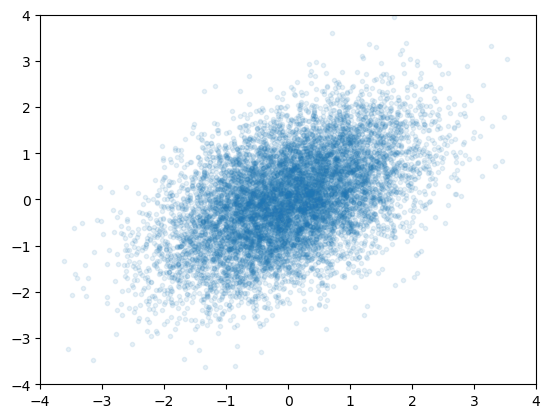

In [2]:
N = 10000
L = np.linalg.cholesky(joint_cov)
samples_from_true_distribution =  L @ np.random.randn(D, N) + joint_mu
plt.plot(*samples_from_true_distribution, '.', alpha=0.1)
plt.axis([-4, 4, -4, 4])
plt.show()

## Conditional probabilities

Gibbs sampling requires conditional distributions for each variable. 

In the case of Gaussians, there is  a closed-form for the conditional. With a [multivariate Gaussian](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w7c_gaussian_processes.html) we have

$$
p(\textbf{f}, \textbf{g}) = 
\mathcal N\left(
\left[\begin{array}{c} \textbf{f} \\ \textbf{g} \end{array}\right];
\left[\begin{array}{c}\textbf{a} \\ \textbf{b}\end{array}\right], 
\left[\begin{array}{cc}A & C^{\top} \\ C & B\end{array}\right]
\right),
$$

with the conditional probability

$$
p(\textbf{f} \mid \textbf{g}) = \mathcal N(\textbf{f}; \textbf{a} + CB^{-1}(\textbf{g} - \textbf{b}), A - CB^{-1}C^{\top}).
$$

In [3]:
def get_conditional_dist(joint_mu, joint_cov, var_index):
    '''Returns the conditional distribution given the joint distribution and which variable
    the conditional probability should use.
    Right now this only works for 2-variable joint distributions.
    
      joint_mu: joint distribution's mu
      joint_cov: joint distribution's covariance
      var_index: index of the variable in the joint distribution. Everything else will be 
        conditioned on. For example, if the joint distribution p(a, b, c) has mu [mu_a, mu_b, mu_c],
        to get p(c | a, b), use var_index = 2.
      
    returns:
      a function that can sample from the univariate conditional distribution
    '''
    assert joint_mu.shape[0] == 2, 'Sorry, this function only works for 2-dimensional joint distributions right now'
    a = joint_mu[var_index]
    b = joint_mu[~var_index]
    
    A = joint_cov[var_index, var_index]
    B = joint_cov[~var_index, ~var_index]
    C = joint_cov[var_index, ~var_index]
    
    # we're dealing with one dimension so
    B_inv = 1/B
    
    # Return a function that can sample given a value of g
    def dist(g):
        # a + C*B^{-1}(g - b)
        mu = a + C * B_inv * (g - b)
        # A - C * B^{-1} * C^T
        cov = A - B_inv * C * C
        return np.sqrt(cov) * np.random.randn(1) + mu
    
    return dist

With this we can set up the conditionals for this problem

In [4]:
# Set up the conditional probability distribution for each dimension
# For example, I can sample p(a | b) using sample_for_dim[0].

univariate_conditionals = [
    get_conditional_dist(joint_mu, joint_cov, d)
    for d in range(D)
]

The $gibbs\_sample$ function here only needs the univariate conditionals and how many samples to take.

In [5]:
def gibbs_sample(univariate_conditionals, sample_count):
    '''Does Gibbs sampling given the distribution's univariate conditionals.
    
    Returns a D x N matrix
    '''
    D = len(univariate_conditionals)
    assert D == 2, "Sorry, this only supports 2 dimensions right now"
    
    # initializes an empty matrix for the samples
    samples = np.zeros((D, sample_count))

    # initialize the first sample to some arbitrary value
    samples[:, 0] = [3, -3]
    
    for i in range(1, sample_count):
        # first set this sample equal to the previous sample
        samples[:, i] = samples[:, i - 1]
        
        # now update the dimension whose turn it is using the conditional distribution
        # pass in all dimension from the previous sample except this dimension
        d = i % D
        samples[d, i] = univariate_conditionals[d](samples[~d, i - 1])
                 
    return samples

One thing to keep in mind about Gibbs sampling is that it only updates
one dimension at a time. This means that samples from around the same
time are correlated with each other. We have drawn the line connecting
sequential samples to show this.

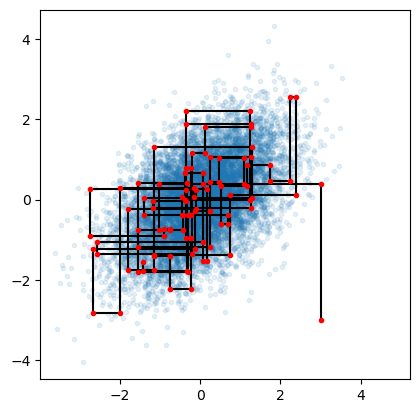

In [6]:
samples = gibbs_sample(univariate_conditionals, sample_count=100)
fig, ax = plt.subplots()

ax.plot(*samples_from_true_distribution, '.', alpha=0.1)
ax.plot(*samples, 'k')
ax.plot(*samples, '.r')
ax.axis('square')
plt.show()

Finally we sample a bunch of points and see how they compare to those
from the original distribution. It looks the same! What's cool is that
the one using Gibbs sampling only used samples from the univariate
conditionals!

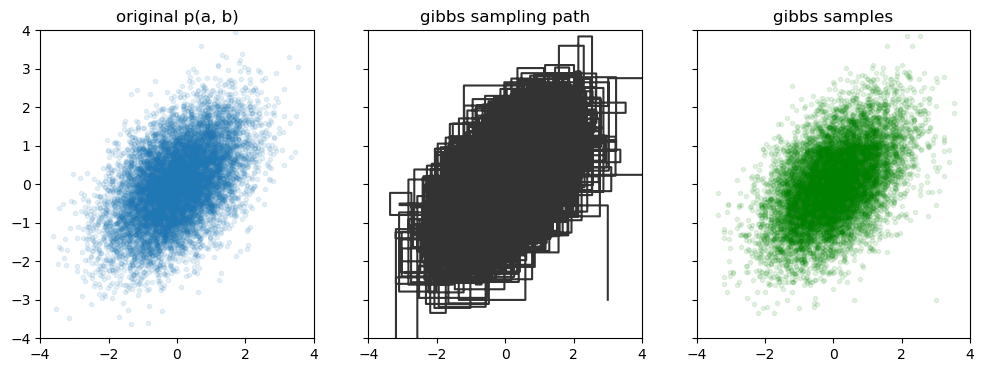

In [7]:
samples = gibbs_sample(univariate_conditionals, sample_count=N)
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
# set all the axes
axs[0].axis([-4, 4, -4, 4])
axs[0].plot(*samples_from_true_distribution, '.', alpha=0.1)
axs[0].set_title('original p(a, b)')
axs[1].plot(*samples, 'k', alpha=0.8)
axs[1].set_title('gibbs sampling path')
axs[2].plot(*samples, '.g', alpha=0.1)
axs[2].set_title('gibbs samples')
plt.show()